---
title: "Constructing a Neural-Net Digit Classifier (Almost) from Scratch"
format:
  html:
    html-math-method: mathjax
---

In [57]:
#| echo: false
#| output: false
import fastbook
fastbook.setup_book()

In [58]:
#| echo: false
#| output: false
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Introduction and Summary 

In this post, I am basically adapting Chapter 4 of the fast.ai book to extend the 3/7 classifier into a digit classifier for all digits.
Just as in the book, I'm going to use the MNIST data set.
The biggest struggles in constructing this classifier were in deciding the loss function in the multi-class case and finding a good learning rate.
What ate up the most time in this project, though, was working with pyTorch tensors.
I would frequently have to change tensors of shape (1,10) to tensors of shape (10) and vice versa.
This was a headache; perhaps it would behoove me to learn a bit more about pyTorch's defaults and conversions.
I've ordered a book to help me with that.

It actually turned out that reading Chapter 5 of the book gave me a lot of the tools I needed to finish this little project.
Before I read the chapter, I was on the right track by computing softmax activations and the likelihoods for each individual observation, but instead of computing the overall likelihood for the loss function, I took the mean likelihood across all observations, which isn't as natural a quantity to compute.
Finally, I was missing the step of taking the log, which doesn't change the mathematical structure of the optimization problem, but I think it has numerical consequences.

## Aside: What is the cross-entropy/negative-log-likelihood? What is the learning rate?

Let's describe what happens in machine learning.
We are given a collection of inputs and outputs $\{x_i,y_i\}$ that are supposed to be related to each other in some way.
For example, each $x_i$ could be the data of an image (the RGB coordinates of each of its pixels) and $y_i$ could be the digit that the image is supposed to represent.
There is supposed to be an abstract relationship between the $x_i$ and $y_i$ and we have a particular noisy sample of such inputs and outputs.
Our goal is to construct a model $M$, whose job is to take in an input $x$ and and "spit out" an output $M(x)$.
Now, we better hope that $M(x_i)$ is (in some way) as close to $y_i$ as possible, since the model needs to be able to predict the actual data we fed into it (but also we want to prevent the model from overgeneralizing features of the particular data set we have fed it!).
An important thing that I've neglected to mention is that $M$ itself is usually part of a family of models, each parametrized by a set of weights, for which I will use the single letter $w$.
So, more properly, we have a collection of predictions $M(w,x)$, one for each value of the parameters $w$ (we consider $x$ to be fixed for now).
I've learned that the name for the family of models is called the *architecture* of the model.
A large fraction of machine learning consists of choosing an appropriate architecture for your problem: you want an architecture flexible enough to find the relationships between inputs and outputs, but not one that is so flexible as to find spurious relationships particular only to the data set you train your model on.

Ok, so how do we describe which value of $w$ is "best"?
We need to measure "how far off" $M(w,x_i)$ is from $y_i$, and aggregate all this information somehow.
One way to do this is to just compute the average accuracy of the predictions $M(w,x_i)$.
The problem is the following: if $w$ and $x_i$ are continuous (numerical) data types, and our output $y_i$ is a discrete data type (which it is in classification problems like the one we're considering), and--- finally---$M(w,x)$ is continuous (or nearly so) with respect to its parameters, then it's "generically" impossible to improve the accuracy of the predictions just by tweaking the weights $w$ a little bit.
But this is pretty much the main way that we can have a computer optimize things: by slightly tweaking the parameters and seeing which small change of parameters improves our desired metric the most.
(The name for this tweaking process is gradient descent.)

So, instead of just predicting the class that each $x_i$ belongs to, we can ask our model to also assign probabilities to those class predictions. So, suppose that we have $N$ different classes (in other words that each $y_i$ is whole number between 1 and $N$), and we provide $N$ functions $P_1(w,x),\ldots, P_j(w,x),\ldots, P_N(w,x)$ which represent the probabilities that the model corresponding to $w$ assigns to a given input $x$ producing each of the $N$ possible outputs.
Since these are probabilities, we need to have $$ P_1(w,x)+P_2(w,x)+\cdots+P_N(w,x)=1$$ and each $P_j$ needs to be non-negative for all $w$ and $x$.
(In math, we say that the functions $\{P_j\}$ provides a function from the space $S$ of parameters and input variables to the $(N-1)$-simplex $\Delta^{N-1}$)
Finally, we can simply set $M(w,x)= \max_{j}P_j(w,x)$.
The beauty of this approach is that now we can more readily measure how good the model $M$ is, and this is called the *likelihood* function.
What it does is tell us how likely our model says the observed data set is.
Assuming that each data point is an independent probabilistic event, we simply multiply the likelihood associated in our model that the output is $y_i$ given $x_i$, i.e., we form $$L(w)= \prod_{i} P_{y_i}(w,x_i).$$
$L(w)$ (conceived of as a function of the parameters $w$) is something that we can seek to optimize, since if the $P$'s have reasonable behavior (e.g. smoothness or continuity), so too will $L(w)$.
In practice, we optimize $\log(L(w))$ instead.
As far as I understand it, this is because since all the probabilities $P_{y_i}$ are less than 1, and there may be thousands that we multiply together, the likelihood will be a very small number, and so it will be hard to detect (given finite precision) improvements in the likelihood.

Now, usually, we have many smart ways of producing a collection of $N$ functions of the parameters and inputs, but we still need to make sure that they are all non-negative and sum to 1.
That's the purpose of the softmax function, which is a map $\mathbb{R}^N \to \Delta^{N-1}$ (it's essentially the simplest such function).
I won't get into the details of that here.

Ok, so now we have a task: given this particular form of $L(w)$, find the $w$ which will minimize $-\log(L(w))$ (which we now call the *loss function*), or at least give us a resonable approximation to the minimum.
This amounts to following a path in the parameter space whose tangent vector is the opposite vector of the gradient.
The way this is typically done is to randomly choose some starting weights $w_0$ and then replace $w_0$ with $w_0 + \eta \nabla_{w}\log(L(w_0))$, where $\eta$ is some small "step size" or "learning rate".
Then we iterate the process until we are reasonably convinced we're close to a minimum.
Only in the limit $\eta\to 0$ is this completely accurate as way to find the minima.
So the smaller $\eta$ is, the more likely we will be to find the minimum of the loss function.
But since $\eta$ is small, if we start with $w_0$ far from the actual minimum, our hair might grow very long while we wait for the iterative process of updating the parameters to bring about meaningful reductions of the loss.
So in practice we have to tweak $\eta$ to give reasonable enough results subject to our time/resource constraints.
I messed around a bit with learning rates and found that .1 was a sufficiently middle-ground learning rate.

Finally, I want to mention that in practice, instead of doing full gradient descent, we take advantage of the particular structure of the loss function to do something more computationally feasible.
Because the likelihood is the product of contributions from each separate data point $(x_i,y_i)$, the loss function is a sum of such contributions.
In each update to the parameters, we can replace the full loss function with the corresponding sum of contributions from a random subset of the full data set.
This is called *stochastic gradient descent*, and I think it makes the gradient descent process more computationally feasible.
And I think the idea is also that it allows us to quickly identify which parameters have the greatest effect on the loss without wasting the resources to compute the full loss.




# Unpacking the Data

We untar the MNIST data set from the fastai library, and name the resulting Path object `path`.

In [59]:
#| output: false
path = untar_data(URLs.MNIST)

In [60]:
#| echo: false
#| hide: false
Path.BASE_PATH = path

We see that the directory consists of a "testing" and "training" folder.

In [61]:
path.ls()

(#2) [Path('training'),Path('testing')]

Within the training folder, there is one folder for each digit.

In [62]:
(path/'training').ls()

(#10) [Path('training/9'),Path('training/0'),Path('training/7'),Path('training/6'),Path('training/1'),Path('training/8'),Path('training/4'),Path('training/3'),Path('training/2'),Path('training/5')]

The list `nums` has ten entries. Each entry is the list of all the file names corresponding to the respective digit.

In [63]:
nums = [(path/'training'/str(i)).ls() for i in range(10)]

# L1 Distance to the Mean Digits

In this section, we compute the mean image for each digit, and then assess the accuracy of the model which assigns to each image the digit whose mean image is closest in L1 norm to the given image.

We form a two-dimensional array of Tensors; the first dimension corresponds to a digit, and the second dimension identifies a particular image.

In [64]:
num_tensors = [[tensor(Image.open(o)) for o in nums[i]] for i in range(10)]


In [65]:
len(num_tensors), len(num_tensors[2])

(10, 5958)

Instead of having a list of tensors for each digit, we stack all the tensors for a given digit into a single Tensor.

In [66]:
stacks = [torch.stack(num_tensors[i]).float()/255 for i in range(10)]
stacks[2].shape

torch.Size([5958, 28, 28])

We compute and display the mean images. It's kind of cool to see the fuzzy gray signifying different slants to vertical components of digits, say in 1, 4, and 9.

[<AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >,
 <AxesSubplot: >]

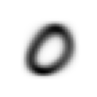

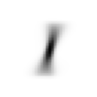

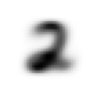

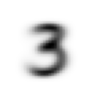

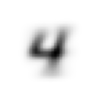

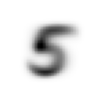

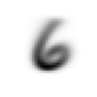

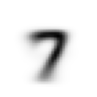

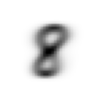

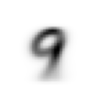

In [67]:
means = [stacks[i].float().mean(0) for i in range(10)]
[show_image(o) for o in means]

Now we test the accuracy of the distance-to-mean model.
First, we unpack the validation set data in the same way as we did for the training data.

In [68]:
#An ordinary Python list of pyTorch tensors, with the validation images for digit i in the ith index.
valids = [torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/str(i)).ls()]) for i in range(10)]
valids = [o.float()/255 for o in valids]

This just measures the L1 distance between two tensors.

In [69]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

The funciton `mnist_distance_list` computes the distance of its input from each of the ten mean digits.
The function `which_is_it` returns the digit with the least distance to its input.

In [70]:
def mnist_distance_list(x):
  dists = [mnist_distance(x,means[i]) for i in range(10)]
  return torch.stack(dists)

def which_is_it(x):
  return torch.argmin(mnist_distance_list(x),dim=0)


Let's test it on an example case:

(tensor([0.1919, 0.1139, 0.1667, 0.1233, 0.1551, 0.1351, 0.1632, 0.1476, 0.1493, 0.1453]),
 tensor(1),
 <AxesSubplot: >)

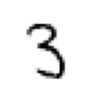

In [71]:
a_3 = stacks[3][2007]
mnist_distance_list(a_3), which_is_it(a_3), show_image(a_3)

The classifier incorrectly classifies this 3 as a 1, although 3 is the second guess of our classifier.

The following couple of cells are basically to test to make sure that `which_is_it` broadcasts correctly with respect to how our validation data are organized.

In [72]:
small_test = stacks[3][0:2]
small_test.shape
mnist_distance_list(small_test[0]), mnist_distance_list(small_test[1]),mnist_distance_list(small_test)


(tensor([0.1783, 0.1153, 0.1520, 0.1144, 0.1579, 0.1366, 0.1683, 0.1565, 0.1416, 0.1568]),
 tensor([0.1692, 0.1246, 0.1621, 0.1234, 0.1649, 0.1344, 0.1612, 0.1602, 0.1557, 0.1616]),
 tensor([[0.1783, 0.1692],
         [0.1153, 0.1246],
         [0.1520, 0.1621],
         [0.1144, 0.1234],
         [0.1579, 0.1649],
         [0.1366, 0.1344],
         [0.1683, 0.1612],
         [0.1565, 0.1602],
         [0.1416, 0.1557],
         [0.1568, 0.1616]]))

In [73]:
which_is_it(small_test[0]),which_is_it(small_test[1]), which_is_it(small_test), which_is_it(small_test)==3

(tensor(3), tensor(3), tensor([3, 3]), tensor([True, True]))

We see that the classifier correctly identifies both of the images as 3s, and `which_is_it`, when given a list of images, produces a rank 1 tensor whose entries are `which_is_it` applied elementwise.

Here, we compute the digit-by-digit accuracies, and then the overall accuracy, which is 67%, which will be our baseline for comparison.

In [74]:
accuracies = [(which_is_it(valids[i])==i).float().mean() for i in range(10)]
overall_accuracy = tensor([accuracies[i]*len(valids[i]) for i in range(10)])
overall_accuracy = overall_accuracy.sum()/10000.
accuracies, overall_accuracy

([tensor(0.8153),
  tensor(0.9982),
  tensor(0.4234),
  tensor(0.6089),
  tensor(0.6680),
  tensor(0.3262),
  tensor(0.7871),
  tensor(0.7646),
  tensor(0.4425),
  tensor(0.7760)],
 tensor(0.6685))

# The Linear Model

Here, we put all of the images into single vectors, instead of 28-by-28 arrays. This is for ease of manipulation of the data.

In [75]:
train_x = torch.cat([stacks[i] for i in range(10)]).view(-1, 28*28)
train_x.shape

torch.Size([60000, 784])

We put together a list of classifications for the training data.

In [76]:
train_y = tensor([])
for i in range (10):
  add = torch.stack([tensor([i]) for j in range(len(nums[i]))])
  train_y=torch.cat((train_y,add),0)
train_y= train_y.squeeze()
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [77]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor(0.))

We do the same for the validation data:

In [78]:
valid_x = torch.cat([valids[i] for i in range(10)]).view(-1, 28*28)
valid_y = tensor([])
for i in range(10):
  add=torch.stack([tensor([i]) for j in range(len(valids[i]))])
  valid_y =torch.cat((valid_y,add),0)
valid_y = valid_y.squeeze()
valid_dset = list(zip(valid_x,valid_y))

In [79]:
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000]))

We define a function to randomly initialize parameters:

In [80]:
def init_params(size, std=1.0): 
  ungrad = (torch.randn(size)*std).squeeze()
  return ungrad.requires_grad_()

In [81]:
weights = init_params((28*28,10))
weights.shape

torch.Size([784, 10])

In [82]:
bias = init_params((1,10))
bias.shape

torch.Size([10])

A check to make sure we're sizing the outputs of `init_parameters` correctly.

In [83]:
((train_x.float()@(weights)) + bias).shape

torch.Size([60000, 10])

The function `linear1` packages `weights` and `bias` together:

In [84]:
def linear1(xb): return xb.float()@weights + bias

We create a batch to make sure our functions work as expected.

In [86]:
preds_log_prob = linear1(train_x)
preds= torch.argmax(preds_log_prob,1)
preds = preds.reshape(60000)
preds.shape, preds

(torch.Size([60000]), tensor([0, 0, 0,  ..., 8, 8, 0]))

In [87]:
corrects = preds.float()==train_y.squeeze()
corrects

tensor([ True,  True,  True,  ..., False, False, False])

We get a pretty bad accuracy, since our weights were just completely random.

In [88]:
corrects.float().mean().item()

0.1610500067472458

Here finally we introduce the loss function by which we have already discussed (the log of likelihood).

In [89]:
def mnist_loss(predictions, targets):
    targets = targets.long()
    losses = F.cross_entropy(predictions,targets.squeeze())
    return losses.mean()

### SGD and Mini-Batches

Re-initialize parameters:

In [182]:
weights = init_params((28*28,10))
bias = init_params(10)

Create a `DataLoader` from our test data. This is the least "from scratch" part of our undertaking.

In [91]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256]))

In [92]:
valid_dl = DataLoader(valid_dset, batch_size=256)

We make a small subset of the training data to make sure the functions are working the right way.

In [93]:
batch = train_x[:4]
batch.shape, train_y[:4].shape

(torch.Size([4, 784]), torch.Size([4]))

We can read off from `preds` that the model predicts digits (0,7,0,9) for the four images in batch. This will explain the .5 accuracy that we compute below.

In [94]:
preds = linear1(batch)
preds, train_y[:4]

(tensor([[ 15.1205, -17.4561,   1.0612,  -7.9669,  -7.6242,   3.3798, -23.8781, -13.1161,   7.8836,   4.6135],
         [  2.9981,  -8.6182, -11.9235, -10.0922,   0.3654,   1.5978,  -9.6981,  13.6491,   0.2252,  -2.6899],
         [ 18.6683, -15.5988,  -0.7190,  -9.8376,  -9.9725,   1.7350, -20.1133, -12.2211,  15.1338,   3.8342],
         [  8.4809,  -5.4655,   5.2217,   3.3916,  -4.6596,   5.9768, -20.8959, -12.0383,  -2.2892,  19.1940]], grad_fn=<AddBackward0>),
 tensor([0., 0., 0., 0.]))

The following few cells contain almost no changes from the corresponding ones in the book.

In [97]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [99]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [100]:
def batch_accuracy(xb, yb):
    preds = torch.argmax(xb,dim=1).squeeze()
    correct = preds.float() == yb.float().squeeze()
    return correct.float().mean()

We can check it works (recall that we computed a 50% accuracy earlier):

In [101]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

and then put the batches together:

In [102]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [103]:
validate_epoch(linear1)

0.189

After some experimentation, I found that it was useful to train for a bit at a learning rate of .1 to give the model a chance to search the parameter space relatively widely, and then to train for many more epochs at .01.

In [183]:
lr = .1
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.1512

In [184]:
for i in range(120):
    train_epoch(linear1, lr, params)
    if (i+1)%15==0:
        print(validate_epoch(linear1), end='\n')

0.6648
0.716
0.7333
0.7397
0.744
0.7475
0.7491
0.7516


In [185]:
for i in range(210):
    train_epoch(linear1, lr=.01, params=params)
    if (i+1)%15==0:
        print(validate_epoch(linear1), end='\n')

0.8886
0.8926
0.8951
0.8958
0.8965
0.8979
0.8981
0.8989
0.8995
0.8998
0.9003
0.9005
0.9009
0.9009


Not bad: 90%

# A Simple Neural Net

Now we turn to the simple neural-net model. It has a linear layer, followed by a RELU layer, followed by a linear layer.
The model is almost identical to the original one, except that we need 10 ouputs from the final layer to give our ten probabilities for the ten digits.
As for the linear model, it made sense to train for a bit with a higher learning rate to get "in the general ballpark", and then to tamp down the learning rate for the fine-tuning.
There is a substantial improvement in the accuracy when we switch to the lower learning rate, and then steady but small gains in each epoch.
Notice also that we train for many more epochs for the neural net because there are many more parameters to tune.

In [106]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [186]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,10))
b2 = init_params(10)

In [187]:
for i in range(420):
  train_epoch(simple_net, lr=.1, params=(w1,b1,w2,b2))
  if (i+1)%15==0:
    print(validate_epoch(simple_net), end='\n')

0.3006
0.3268
0.3543
0.3865
0.4399
0.5045
0.5327
0.5451
0.5581
0.5689
0.5795
0.5942
0.6057
0.6154
0.6221
0.6309
0.6379
0.6435
0.6496
0.6565
0.6628
0.6702
0.6772
0.6831
0.6895
0.6943
0.6983
0.7035


Let's set it to train for 780 epochs, go have lunch, and then come back:

In [188]:
for i in range(780):
  train_epoch(simple_net, lr=.01, params=(w1,b1,w2,b2))
  if (i+1)%15==0:
    print(validate_epoch(simple_net), end='\n')

0.9082
0.9089
0.9093
0.9096
0.9099
0.9103
0.9103
0.9106
0.9114
0.912
0.9125
0.9124
0.9129
0.9132
0.9134
0.9141
0.9142
0.9145
0.9147
0.9147
0.9154
0.9156
0.9159
0.9161
0.9165
0.9169
0.9174
0.9177
0.9183
0.9186
0.9187
0.9193
0.9196
0.92
0.9201
0.9206
0.921
0.9216
0.9219
0.922
0.922
0.9224
0.9228
0.9226
0.9229
0.9249
0.9249
0.9254
0.9256
0.9254
0.9258
0.9263


Our final accuracy with the simple neural-net is pretty good: 93% almost!